### Downsample specsim output to log-10 A wavelength grid for eBOSS

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import specsim.simulator

In [417]:
simulator = specsim.simulator.Simulator('eboss', num_fibers=1)
simulator.atmosphere
simulator.simulate()

blue_output = simulator.camera_output[0]
red_output = simulator.camera_output[1]

sim = simulator.simulated

b_wlen, r_wlen = blue_output['wavelength'], red_output['wavelength']
b_flux, r_flux = blue_output['observed_flux'], red_output['observed_flux']

/Users/belaabolfathi/anaconda3/envs/galsim/lib/python3.6/site-packages/speclite/filters.py:1461: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


In [4]:
eboss_wlen = np.load('b_loglam.npy')

### Test cases for resampled functions (sanity check)

In [5]:
def resample_binned(edges_out, edges_in, hist_in, axis=-1, zero_pad=True):
    """Flux conserving linear resampler of binned data.
    Parameters
    ----------
    edges_out : array
        1D array of M >= 2 output bin edges, in increasing order.
    edges_in : array
        1D array of N >= 2 input bin edges, in increasing order.
    hist_in : array
        Array with N-1 input bin values indexed by the specified axis.
    axis : int
        Axis of hist_in used to index input histogram values.
    zero_pad : bool
        When True, allow the output edges to extend beyond the input
        edges and assume that the input histogram is zero outside of
        its extent.  When False, raises a ValueError if extrapolation
        would be required.
    Returns
    -------
    array
        1D array of M-1 resampled bin values.
    """
    # Check input 1D arrays.
    edges_out = np.asarray(edges_out)
    edges_in = np.asarray(edges_in)
    if edges_out.ndim != 1:
        raise ValueError('Expected 1D edges_out.')
    if edges_in.ndim != 1:
        raise ValueError('Expected 1D edges_in.')
    if len(edges_out) < 2:
        raise ValueError('Need at least one output bin.')
    if len(edges_in) < 2:
        raise ValueError('Need at least one input bin.')
    binsize_out = np.diff(edges_out)
    if np.any(binsize_out <= 0):
        raise ValueError('Expecting increasing edges_out.')
    binsize_in = np.diff(edges_in)
    if np.any(binsize_in <= 0):
        raise ValueError('Expecting increasing edges_in.')
    if not zero_pad and ((edges_out[0] < edges_in[0]) or
                         (edges_out[-1] > edges_in[-1])):
        raise ValueError(
            'Ouput bins extend beyond input bins but zero_pad is False.')
    if (edges_out[0] >= edges_in[-1]) or (edges_out[-1] <= edges_in[0]):
        raise ValueError('Input and output bins do not overlap.')
    # Check input histogram(s) and put index in axis 0. Note that we
    # use moveaxis instead of rollaxis since it is easier to invert.
    hist_in = np.asarray(hist_in)
    hist_in_rolled = np.moveaxis(hist_in, axis, 0)
    if len(hist_in_rolled) != len(edges_in) - 1:
        raise ValueError(
            'Unexpected length of hist_in along axis {}.'.format(axis))
    # Align output edges to input edges.
    idx = np.searchsorted(edges_in, edges_out)
    # Loop over output bins.
    nin = len(edges_in) - 1
    nout = len(edges_out) - 1
    hist_out_rolled_shape = (nout,) + hist_in_rolled.shape[1:]
    hist_out_rolled = np.zeros(hist_out_rolled_shape)
    hi = idx[0]
    for i in range(nout):
        lo = hi
        hi = idx[i + 1]
        if (lo > nin) or (hi == 0):
            # This bin does not overlap the input.
            continue
        if lo == hi:
            # Output bin is fully embedded within an input bin:
            # give it a linear share.
            hist_out_rolled[i] = (
                binsize_out[i] / binsize_in[lo - 1] * hist_in_rolled[lo - 1])
            continue
        # Calculate fraction of first input bin overlapping this output bin.
        if lo > 0:
            hist_out_rolled[i] += (
                hist_in_rolled[lo - 1] / binsize_in[lo - 1] * (
                    edges_in[lo] - edges_out[i]))
        # Calculate fraction of last input bin overlaping this output bin.
        if hi <= nin:
            hist_out_rolled[i] += (
                hist_in_rolled[hi - 1] / binsize_in[hi - 1] * (
                    edges_out[i + 1] - edges_in[hi - 1]))
        # Add input bins fully contained within this output bin.
        if hi > lo + 1:
            hist_out_rolled[i] += np.sum(hist_in_rolled[lo:hi - 1], axis=0)
    # Return our unrolled output histogram.
    return np.moveaxis(hist_out_rolled, axis, 0)

In [34]:
dat = np.random.normal(loc=0, scale=1.0, size=100)
edges_in = np.arange(-3,4,1)
hist_in, _ = np.histogram(dat, edges_in)
edges_out = np.arange(-3,4,2)

In [35]:
hist_out = resample_binned(edges_out, edges_in, hist_in)

In [40]:
mdpt_in = 0.5 * (edges_in[1:] + edges_in[:-1])

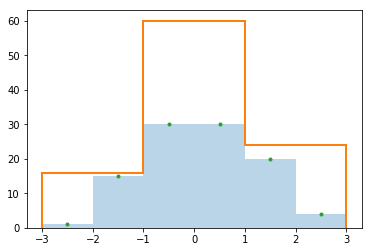

In [46]:
plt.hist(dat, bins=edges_in, alpha=0.3)
plt.hist(dat, bins=edges_out, histtype='step', lw=2)
plt.plot(mdpt_in, hist_in, '.')
plt.show()

Good - works as we would expect. Now I want to write my own downsampling function, do it the long way first so that I understand each step of what is going on. After this I will verify that I get the same result using `skysim.utils.resample_density()` then `skysim.utils.resample_binned()`. 

The first thing we need to do is to convert from flux density to counts. We do this by multiplying the flux by the bin width. Create `b_edges` so that the midpoint of each bin is centered on the values `b_wlen`.

Note: some of the `b_flux` and `r_flux` values are nan's ... need to look into this (maybe has to do with how throughput is calculated for wavelength values that fall outside of the wavelength grid for each camera?)

In [83]:
## Bin width
b_diff = np.diff(b_wlen)
print(np.all(b_diff[0] == b_diff))
b_diff = b_diff[0]

True


In [133]:
## Define nominal bin edges
b_edges = b_wlen - (0.5 * b_diff)
b_edges = np.append(b_edges, b_edges[-1] + b_diff)
b_edges = np.log10(b_edges)

#### ** NEED TO FIX NAN ISSUE **

In [419]:
b_flux[np.isnan(b_flux)] = 0.0

In [420]:
b_counts = b_flux * b_diff
## b_counts, b_edges is our simulation histogram

In [422]:
## Define eBOSS bin edges
eboss_wlen = np.load('b_loglam.npy')
eboss_diff = np.diff(eboss_wlen)
eboss_diff_app = np.append(eboss_diff, eboss_diff[-1])
eboss_edges = eboss_wlen - (0.5 * eboss_diff_app)
eboss_edges = np.append(eboss_edges, eboss_edges[-1] + eboss_diff_app[-1])

In [423]:
idx_in_eboss = np.searchsorted(eboss_edges, b_edges)

In [424]:
output_hist = np.zeros_like(eboss_wlen)
flux_right = 0
prev_idx = -1

for i in range(len(idx_in_eboss) - 1):
    if np.isnan(output_hist[idx_in_eboss[i]]):
        print(i)
    output_hist[idx_in_eboss[i] - 1] += flux_right
    if prev_idx == idx_in_eboss[i+1]:
        output_hist[prev_idx - 1] += b_counts[i]
    else:
        diff = idx_in_eboss[i+1] - idx_in_eboss[i]
        if diff == 0:
            output_hist[idx_in_eboss[i] - 1] += b_counts[i]
            flux_right = 0
            prev_idx = idx_in_eboss[i]
        elif diff > 0:
            left = (eboss_edges[idx_in_eboss[i]] - b_edges[i]) / (b_edges[i+1] - b_edges[i])
            right = 1 - left
            flux_left = left * b_counts[i]
            flux_right = right * b_counts[i]
            #assert (flux_right + flux_left) == b_counts[i]
            output_hist[idx_in_eboss[i] - 1] += flux_left

In [444]:
assert np.allclose(np.sum(output_hist), np.sum(b_counts))

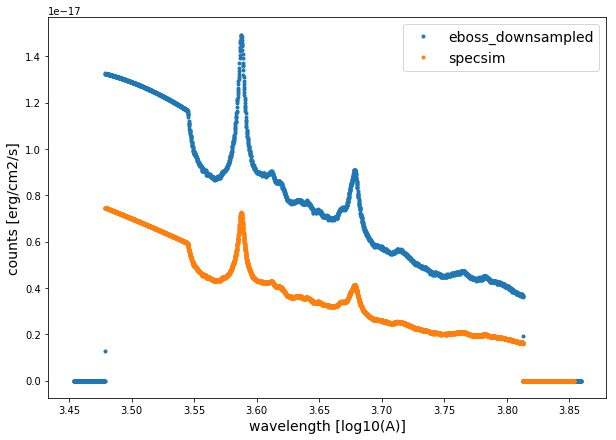

In [459]:
fs = 14
plt.figure(figsize=(10,7))
plt.plot(eboss_wlen, output_hist, '.', label='eboss_downsampled')
plt.plot(np.log10(b_wlen), b_counts, '.', label='specsim')
plt.xlabel('wavelength [log10(A)]', fontsize=fs)
plt.ylabel('counts [erg/cm2/s]', fontsize=fs)
plt.legend(fontsize=fs)
plt.show()

Makes sense that it conserves flux even though it has higher counts at each wavelength because the wavelength grid is more sparse for the downsampled curve (specsim is more densely sampled).

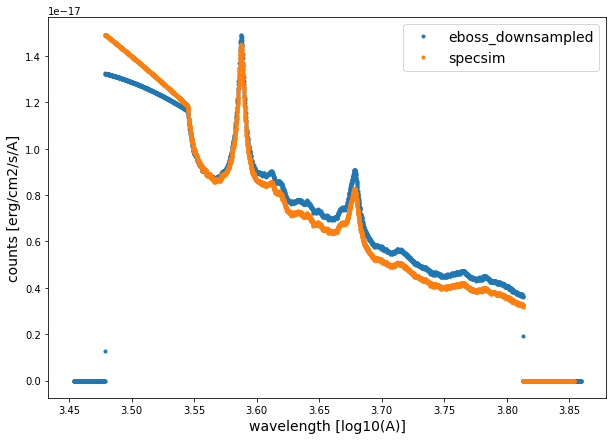

In [466]:
plt.figure(figsize=(10,7))
plt.plot(eboss_wlen, output_hist / (10 ** np.diff(eboss_edges)), '.', label='eboss_downsampled')
plt.plot(np.log10(b_wlen), b_flux, '.', label='specsim')
plt.xlabel('wavelength [log10(A)]', fontsize=fs)
plt.ylabel('counts [erg/cm2/s/A]', fontsize=fs)
plt.legend(fontsize=fs)
plt.show()